# **Histopathologic Cancer Detection (Kaggle)**

### **Project Objective**

To build a deep learning model that accurately identifies metastatic cancer tissue in 96x96px histopathologic image patches. The model must predict the probability that the center 32x32px region contains tumor tissue.

**Competition Metric:** ROC AUC

### **Project Workflow**

This notebook is designed to be flexible and supports two distinct run modes, managed by the CFG class:

1. **Training (on Google Colab Pro):**  
   * Set CFG.TRAINING \= True and CFG.INFERENCE \= False.  
   * Run on Colab Pro with high-performance GPUs (V100/A100) and High-RAM.  
   * Data will be downloaded via the Kaggle API to the local Colab VM.  
   * This mode will run the full K-Fold training and save the resulting model weights.  
   * Model weights (.h5 or .pth) should be manually saved (e.g., to Google Drive) and then uploaded as a private **Kaggle Dataset**.  
2. **Inference (on Kaggle Notebooks):**  
   * Set CFG.TRAINING \= False and CFG.INFERENCE \= True.  
   * This notebook will be run on the Kaggle platform for submission.  
   * It will **not** run training.  
   * It will load the pre-trained model weights from the private Kaggle Dataset created in Step 1\.  
   * It will run inference (with TTA) on the official test/ dataset and generate submission.csv.

## 1. Setup & Configuration
This central CFG (Configuration) class holds all hyperparameters and environment settings.

In [1]:
# [CODE CELL]
class CFG:
    # --- Workflow Control ---
    # Set to True on Colab Pro for training
    TRAINING = True
    # Set to True on Kaggle for submission
    INFERENCE = False
    # Set to True for a quick run on a small data sample
    DEBUG = False

    # --- Environment ---
    PLATFORM = "Colab" # "Kaggle" or "Colab"
    SEED = 42

    # --- Data ---
    IMAGE_SIZE = (96, 96)
    N_CHANNELS = 3

    # --- Model ---
    MODEL_NAME = 'EfficientNetB0' # e.g., 'EfficientNetB0', 'ResNet50'
    PRETRAINED_WEIGHTS = 'imagenet'

    # --- Training ---
    N_FOLDS = 5
    EPOCHS = 20
    BATCH_SIZE = 64
    LEARNING_RATE = 1e-4
    LR_REDUCE_PATIENCE = 3
    EARLY_STOPPING_PATIENCE = 5

    # --- TTA (Test Time Augmentation) ---
    TTA_STEPS = 5 # Number of augmented predictions to average (incl. original)

# --- Utility Function for Seeding ---
def seed_everything(seed=CFG.SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


In [2]:
# [CODE CELL]
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import random

print(f"TensorFlow Version: {tf.__version__}")


TensorFlow Version: 2.19.0


## Data Setup

In [3]:
# --- Define Paths ---
if CFG.PLATFORM == "Kaggle":
    # Running on Kaggle, data is pre-mounted
    BASE_PATH = "/kaggle/input/histopathologic-cancer-detection"
    MODEL_WEIGHTS_PATH = "/kaggle/input/my-cancer-model-weights" # Path to your private Kaggle Dataset

elif CFG.PLATFORM == "Colab":
    from google.colab import drive
    import os

    # 1. 挂载 Google Drive
    print("正在挂载 Google Drive...")
    drive.mount('/content/drive')

    # --- 2. 定义路径 ---
    # 你在 Drive 上的 ZIP 文件路径 (根据你的截图)
    GDRIVE_ZIP_PATH = "/content/drive/MyDrive/Kaggle_Datasets/histopathologic-cancer/histopathologic-cancer-detection.zip"

    # 我们要解压到 Colab 本地的临时路径
    LOCAL_DATA_PATH = "/content/data"

    # 我们用标签文件作为“是否已解压”的检查点
    CHECK_FILE_PATH = os.path.join(LOCAL_DATA_PATH, "train_labels.csv")

    # --- 3. 检查是否已解压，如果未解压，则执行解压 ---
    # 这样你重新运行单元格时，如果文件已在，就不用浪费时间再次解压
    if not os.path.exists(CHECK_FILE_PATH):
        print(f"在 {LOCAL_DATA_PATH} 未找到数据...")
        print(f"正在从 Google Drive ({GDRIVE_ZIP_PATH}) 解压文件...")

        # 确保目标目录存在
        os.makedirs(LOCAL_DATA_PATH, exist_ok=True)

        # 从 Drive 解压到 Colab 本地 (-q 参数是“安静模式”，减少输出)
        !unzip -q "$GDRIVE_ZIP_PATH" -d "$LOCAL_DATA_PATH"

        print("解压完成！")
    else:
        print(f"数据已存在于 {LOCAL_DATA_PATH}。跳过解压。")

    # --- 4. 设置你代码中使用的路径 ---
    # BASE_PATH 现在指向 Colab 的本地路径
    BASE_PATH = LOCAL_DATA_PATH

    # 模型权重路径 (你原来的设置很好，保持在 Drive 上)
    MODEL_WEIGHTS_PATH = "/content/drive/MyDrive/Kaggle/PADCancer/weights"
    if not os.path.exists(MODEL_WEIGHTS_PATH):
        os.makedirs(MODEL_WEIGHTS_PATH)

TRAIN_PATH = os.path.join(BASE_PATH, "train")
TEST_PATH = os.path.join(BASE_PATH, "test")
LABELS_PATH = os.path.join(BASE_PATH, "train_labels.csv")

# --- Load Labels ---
df_labels = pd.read_csv(LABELS_PATH)

# Add image file path
df_labels['file_path'] = df_labels['id'].apply(lambda x: os.path.join(TRAIN_PATH, x + '.tif'))
# Convert label to string for flow_from_dataframe
df_labels['label_str'] = df_labels['label'].astype(str)

# --- Debug Mode ---
if CFG.DEBUG:
    print("--- DEBUG MODE ENABLED ---")
    # Use a small, stratified sample
    _, df_labels = train_test_split(
        df_labels,
        test_size=0.01,
        stratify=df_labels['label'],
        random_state=CFG.SEED
    )
    print(f"Running in debug mode with {len(df_labels)} samples.")

print(f"Total training samples: {len(df_labels)}")
df_labels.head()

正在挂载 Google Drive...
Mounted at /content/drive
在 /content/data 未找到数据...
正在从 Google Drive (/content/drive/MyDrive/Kaggle_Datasets/histopathologic-cancer/histopathologic-cancer-detection.zip) 解压文件...
解压完成！
Total training samples: 220025


,id,label,file_path,label_str
0,f38a6374c348f90b587e046aac6079959adf3835,0,/content/data/train/f38a6374c348f90b587e046aac...,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/content/data/train/c18f2d887b7ae4f6742ee44511...,1
2,755db6279dae599ebb4d39a9123cce439965282d,0,/content/data/train/755db6279dae599ebb4d39a912...,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/content/data/train/bc3f0c64fb968ff4a8bd33af69...,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/content/data/train/068aba587a4950175d04c680d3...,0


## **3\. EDA**

Check if the dataset is balanced.

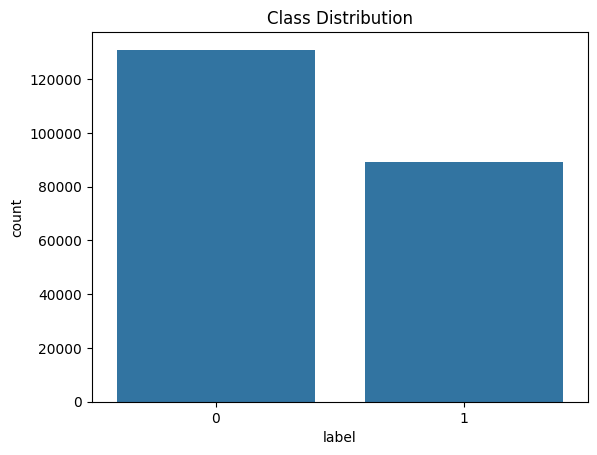

label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


In [4]:
# [CODE CELL]
sns.countplot(x='label', data=df_labels)
plt.title('Class Distribution')
plt.show()
print(df_labels['label'].value_counts(normalize=True))


View Sample Images